In [38]:
import torch
import tqdm
import matplotlib.pyplot as plt
from utils import display_img, process
from latent_dataset import WPlusLatentsDataset
from SAE import SparseAutoencoder
import dnnlib
import legacy
from latent_dataset import save_latents
from torch.utils.data import DataLoader
from evaluate_saes import test_reconstructions

# Setup Model and Data

In [2]:
# downloaded from https://catalog.ngc.nvidia.com/orgs/nvidia/teams/research/models/stylegan2/files

FILEPATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/load_pretrained_stylegan/stylegan2-celebahq-256x256.pkl'
with dnnlib.util.open_url(FILEPATH) as f:
    data = legacy.load_network_pkl(f)
    G = data["G_ema"].eval().to("mps")

In [3]:
# # Save latents to folders
# TRAIN_LATENTS_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_train_latents'
# TEST_LATENTS_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_test_latents'
# save_latents(G, TRAIN_LATENTS_PATH, num_batches = 10000, device = 'mps', batch_size = 64, use_w_plus = False)
# save_latents(G, TRAIN_LATENTS_PATH, num_batches = 1000, device = 'mps', batch_size = 64, use_w_plus = False)

In [3]:
device = 'mps'

In [4]:
TRAIN_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_train_latents'
train_data = WPlusLatentsDataset(TRAIN_PATH)
TEST_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_test_latents'
test_data = WPlusLatentsDataset(TEST_PATH)

In [5]:
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = True)

# Train SAES

In [7]:
SAE = SparseAutoencoder(latent_dim = 512, hidden_dim = 1024, sparsity_lambda = 0.5, device = device).to(device)

In [8]:
def train_sae_epoch(sae, loader, optimizer):
    total_losses = []
    reconstruction_losses = []
    sparsity_losses = []
    for batch in loader:
        optimizer.zero_grad()
        batch = batch.to(sae.device)
        reconstructions, latents = sae(batch)
        total_loss, reconstruction_loss, sparsity_loss = sae.loss(batch, reconstructions, latents)
        total_loss.backward()
        optimizer.step()
        total_losses.append(total_loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        sparsity_losses.append(sparsity_loss.item())
    return total_losses, reconstruction_losses, sparsity_losses

def train_sae(sae, loader, optimizer, num_epochs, num_epochs_per_resampling):
    all_total_losses = []
    all_reconstruction_losses = []
    all_sparsity_losses = []
    for i in tqdm.tqdm(range(num_epochs)):
        total_losses, reconstruction_losses, sparsity_losses = train_sae_epoch(sae, loader, optimizer)
        all_total_losses.extend(total_losses)
        all_reconstruction_losses.extend(reconstruction_losses)
        all_sparsity_losses.extend(sparsity_losses)
        if i % num_epochs_per_resampling == 0:
            pass
    return all_total_losses, all_reconstruction_losses, all_sparsity_losses

In [9]:
optimizer = torch.optim.Adam(params = SAE.parameters(), lr = 1e-3)

In [10]:
total_losses, reconstruction_losses, sparsity_losses = train_sae(SAE, train_loader, optimizer, 10, 10)

100%|██████████| 10/10 [03:35<00:00, 21.54s/it]


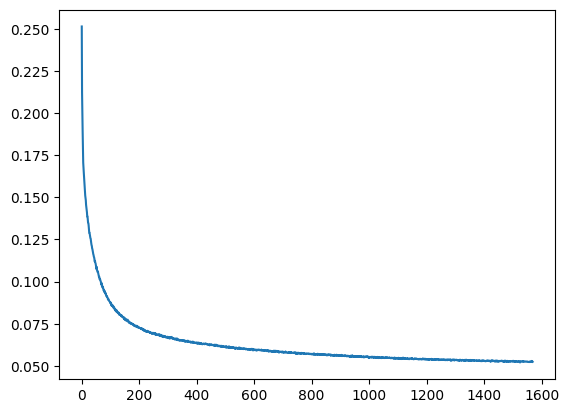

In [11]:
plt.plot(total_losses)
plt.show()

In [170]:
log_losses = torch.tensor(total_losses)
log_losses = torch.log(log_losses)
plt.plot(log_losses)
plt.show()

NameError: name 'total_losses' is not defined

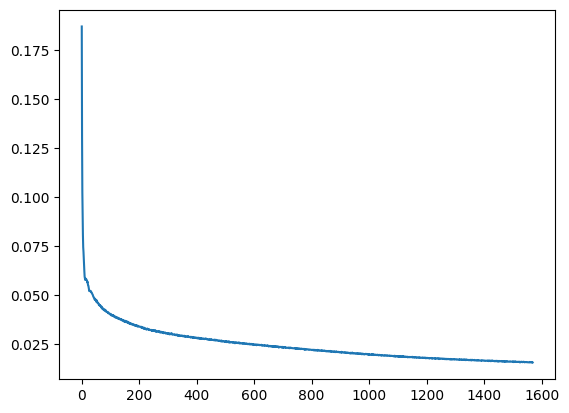

In [12]:
plt.plot(reconstruction_losses)
plt.show()

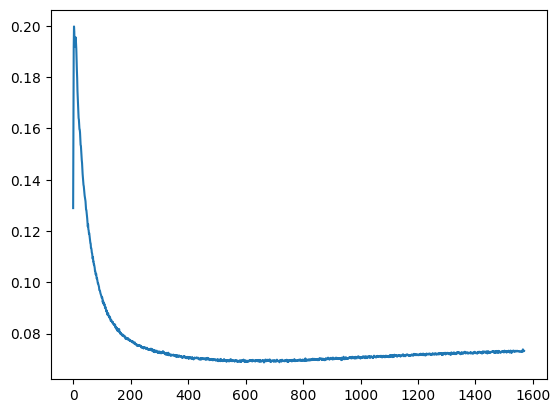

In [13]:
plt.plot(sparsity_losses)
plt.show()

In [7]:
SAE = torch.load('/Users/spra/Desktop/Personal Projects/CV_final_project/Image-Steering-SAEs/sae1024_10epochs.pt', weights_only = False)

Original Images:
Reconstructed Images


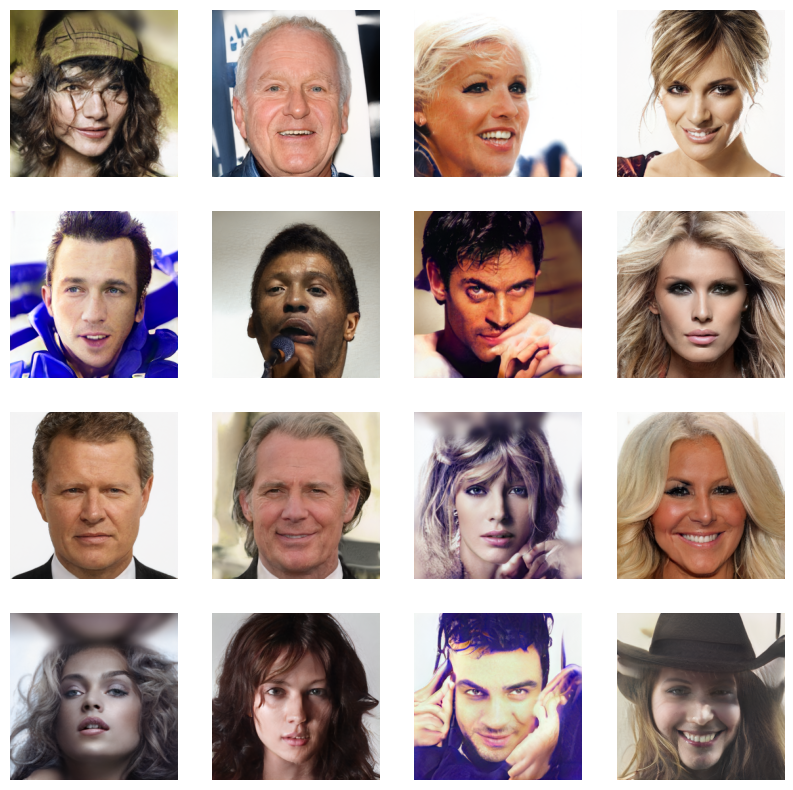

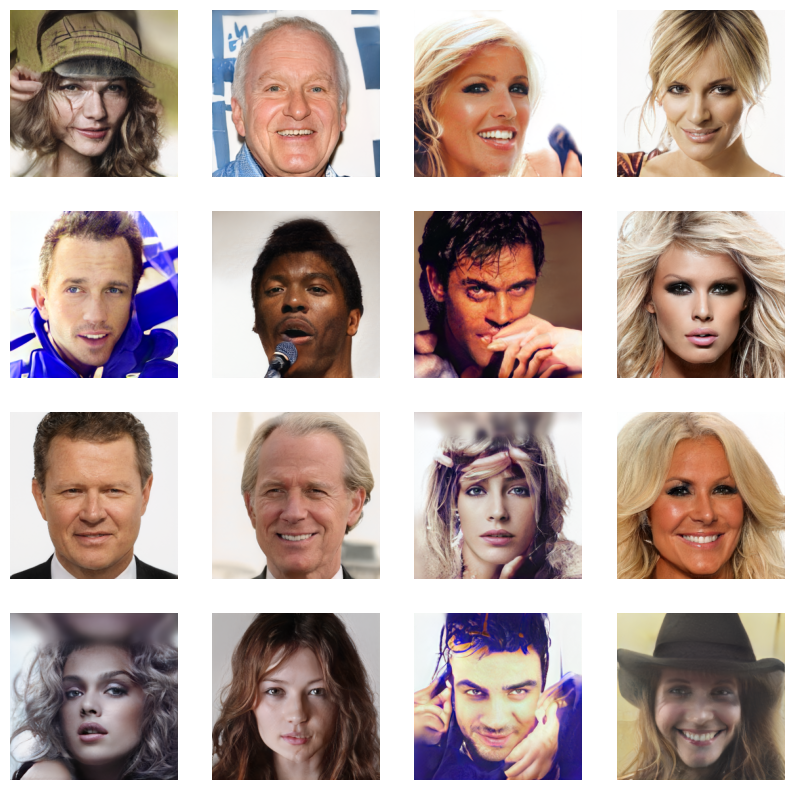

In [10]:
imgs, reconstructed_imgs = test_reconstructions(G, SAE, test_loader, h = 4, w = 4, display = True)

In [12]:
import einops

In [13]:
num_images = 128

In [15]:
sae = SAE

In [16]:
noise = torch.randn((num_images, G.z_dim), device = device)
c = None
with torch.no_grad():
    w = G.mapping(noise, c)
    # to take out the middle dimension of 14
    w = w[:, 0, :]
    reconstructions, sparse_representations = sae(w)
    w = einops.repeat(w, 'b d -> b l d', l = 14)
    images = G.synthesis(w)
    # images should be a tensor of shape (batch_size, 3, 256, 256)
    # sparse_representations should be a tensor of shape (batch_size, 1024)

In [47]:
freqs = sparse_representations.mean(dim = 0)
maxes, freq_indices = torch.topk(freqs, k = 20)
print(f'Maxes: {maxes}')
print(f'Indices: {freq_indices}')

Maxes: tensor([4.9441, 2.9408, 2.7001, 2.2159, 1.5835, 1.4530, 1.1736, 1.0525, 1.0467,
        0.9659, 0.9166, 0.8370, 0.7519, 0.7193, 0.7081, 0.6619, 0.6350, 0.6215,
        0.5721, 0.5609], device='mps:0')
Indices: tensor([ 298,  613,  698,    2,  178,  424, 1002,  724,  891,  767,  394,  581,
         888,   54,  794,  529,    5,  309,  365,  148], device='mps:0')


In [78]:
def visualize_latent(sparse_representations, images, idx):
    # top_indices and bottom_indices are tensors of shape (k, latent_dim), which is usually (16, 1024)
    topk, top_indices = torch.topk(sparse_representations, k = 16, dim = 0, largest = True)
    bottomk, bottom_indices = torch.topk(sparse_representations, k = 16, dim = 0, largest = False)
    # were only taking the topk for the latent we choose using idx
    top_chosen_indices = top_indices[:, idx]
    top_activations = topk[:, idx]
    bottom_chosen_indices = bottom_indices[:, idx]
    bottom_activations = bottomk[:, idx]
    top_images = process(images[top_chosen_indices])
    bottom_images = process(images[bottom_chosen_indices])
    return top_images, bottom_images, top_activations, bottom_activations

In [100]:
top, bottom, top_activations, bottom_activations = visualize_latent(sparse_representations, images, 2)

In [101]:
top_activations

tensor([8.0716, 7.9972, 7.5684, 7.5567, 7.4652, 7.4153, 7.3241, 7.2807, 6.8153,
        6.2821, 6.2533, 5.8935, 5.6003, 5.4624, 5.2832, 5.2012],
       device='mps:0')

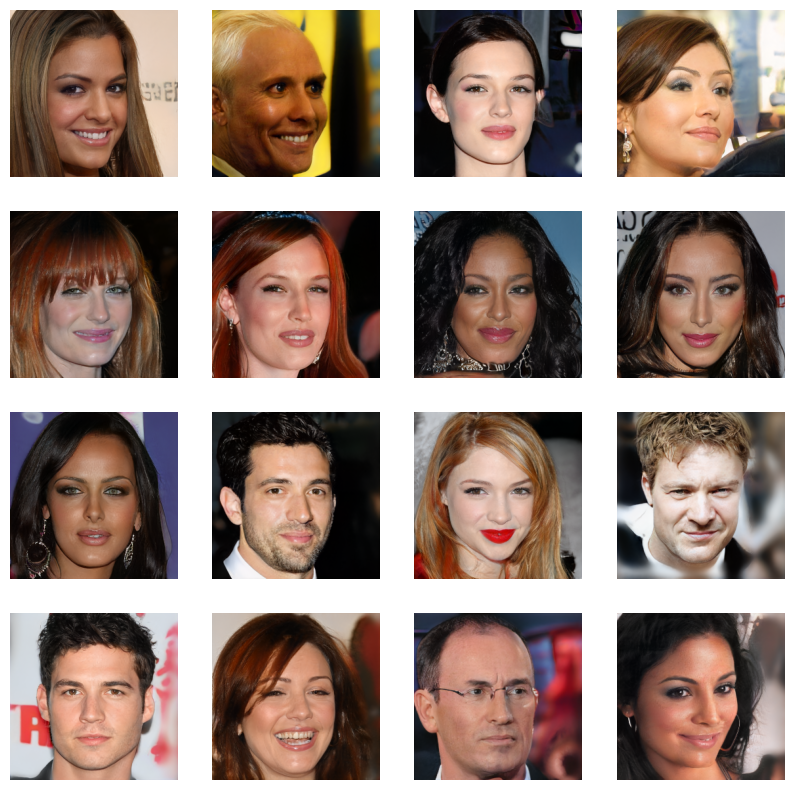

In [102]:
display_img(top, h = 4, w = 4)

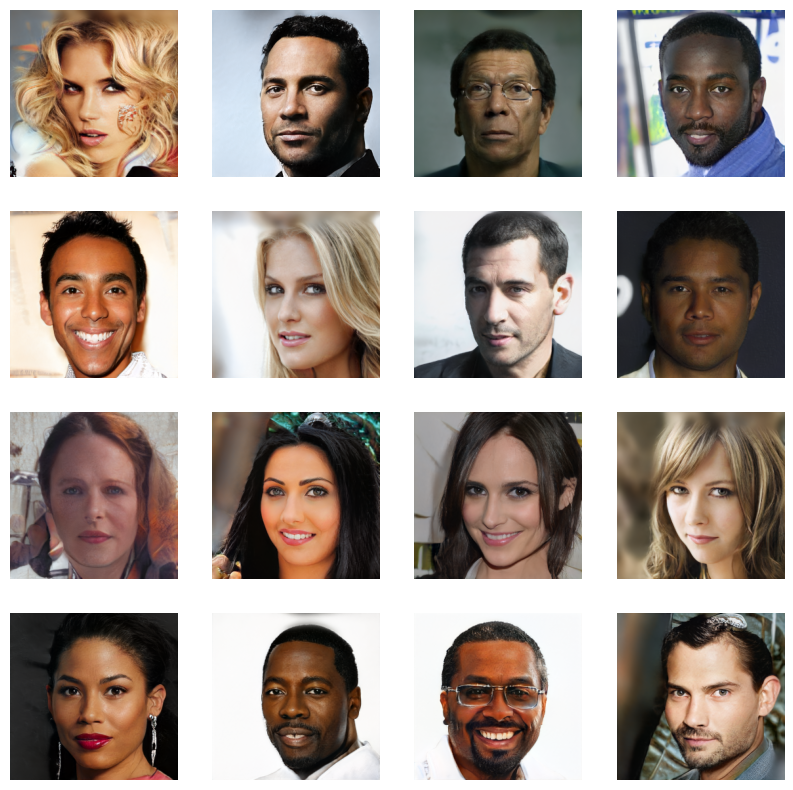

In [103]:
display_img(bottom, h = 4, w = 4)

In [ ]:
def get_top_k_images(G, sae, num_images = 128, k = 16, device = 'mps'):
    ''' 
    Take a trained SAE and generate images using random noise
    '''
    noise = torch.randn((num_images, G.z_dim), device = device)
    c = None
    with torch.no_grad():
        w = G.mapping(noise, c)
        # to take out the middle dimension of 14
        w = w[:, 0, :]
        reconstructions, sparse_representations = sae(w)
        w = einops.repeat(w, 'b d -> b l d', l = 14)
        images = G.synthesis(w)
        # images should be a tensor of shape (batch_size, 3, 256, 256)
        # sparse_representations should be a tensor of shape (batch_size, 1024)
        topk, indices = 


In [ ]:
# latent number 2 is looking from left, vs looking from the right
# latent numbers 298 and 613 seem to be somethign about long hair vs short hair?
# 178 seems to be about hats?